![header](header.png)

# Procesamiento Digital de Señales en Sistemas Embebidos

---

# Actividad: Análisis Frecuencial

## Introducción
El análisis de señales en el dominio de la frecuencia muestra cómo se distribuye la amplitud de la señal en un rango de frecuencias. En algunos casos la información relevante puede estar oculta en el dominio de la frecuencia en lugar del dominio del tiempo.

Por lo tanto, la transformada de Fourier (FT) es esencial para representar la señal en un dominio de frecuencia utilizando ondas sinusoidales. Esta representación proporciona una perspectiva alternativa donde se puede monitorear la magnitud de las señales dentro de una banda de frecuencia dada. Entre las FT, la transformada discreta de Fourier (DTF) se considera la más rápida  pero se requiere una transformada rápida de Fourier (FFT) para calcular la DTF.
El espectro de magnitud de las señales puede servir además como base para la obtención de parámetros específicos que facilitan el reconocimiento de ciertas señales, por ejemplo el cálculo de Perfiles de Clase de Tonos (Pitch Class Profile) para la identificación de acordes, o la obtención de Coeficientes Cepstrales de Frecuencia de Mel (MFCCs) para análisis del habla.

![scheme](scheme.png)

## Consignas
En la carpeta ``ejemplos_python/frequency_analysis`` del Repositorio se dispone de grabaciones de audio (en formato WAV) de notas tocadas en distintos instrumentos y acordes grabados a partir de una guitarra.
1. A partir de estas señales de audio se pide implementar un programa que corra en un ESP32 y que le permita:
    1. Calcular la transformada de Fourier para los distintos audios. 
    2. Graficar la magnitud del espectro en frecuencia de las señales.
    3. Para cada una de ellas, hallar la frecuencia central de los distintos tonos que lo componen.
2. Implementar un programa que corra en un ESP32 y que le permita:
    1. Adquirir en forma contínua señales de audio a una frecuencia determinada (utilizando el micrófono conectado a una entrada del CAD del ESP32).
    2. Calcular en tiempo real la FFT de la señal por bloques.
    3. Hallar la frecuencia central de los distintos tonos que componen la señal adquirida.


In [1]:
# Incluir librerías
from scipy import signal
from scipy import fft
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

## Lectura del archivo de audio

In [44]:
filename = 'silbido'                       # nombre de archivo
fs, data = wavfile.read(f'{filename}.wav') # frecuencia de muestreo y datos de la señal

Definición de parámetros temporales:

In [45]:
ts = 1 / fs                             # tiempo de muestreo
N = len(data)                           # número de muestras en el archivo de audio
t = np.linspace(0, N * ts, N)           # vector de tiempo
if len(data.shape) > 1:
    senial = data[:, 0]                 # Si el audio es estereo, se extrae un canal de la pista 
else:
    senial = data   
senial = senial * 3300.0 / (2 ** 16 - 1)# se escala la señal a mV (considerando un CAD de 16bits y Vref 3.3V)

## Cálculo de la FFT

In [46]:
freq = fft.fftfreq(N, d=1/fs)   # se genera el vector de frecuencias
senial_fft = fft.fft(senial)    # se calcula la transformada rápida de Fourier

# El espectro es simétrico, nos quedamos solo con el semieje positivo
f = freq[np.where(freq >= 0)]      
#senial_fft = senial_fft[np.where(freq >= 0)]

# Se calcula la magnitud del espectro
senial_fft_mod = np.abs(senial_fft) / N     # Respetando la relación de Parceval
# Al haberse descartado la mitad del espectro, para conservar la energía 
# original de la señal, se debe multiplicar la mitad restante por dos (excepto
# en 0 y fm/2)
#senial_fft_mod[1:len(senial_fft_mod-1)] = 2 * senial_fft_mod[1:len(senial_fft_mod-1)]

## Graficación de la señal y su espectro

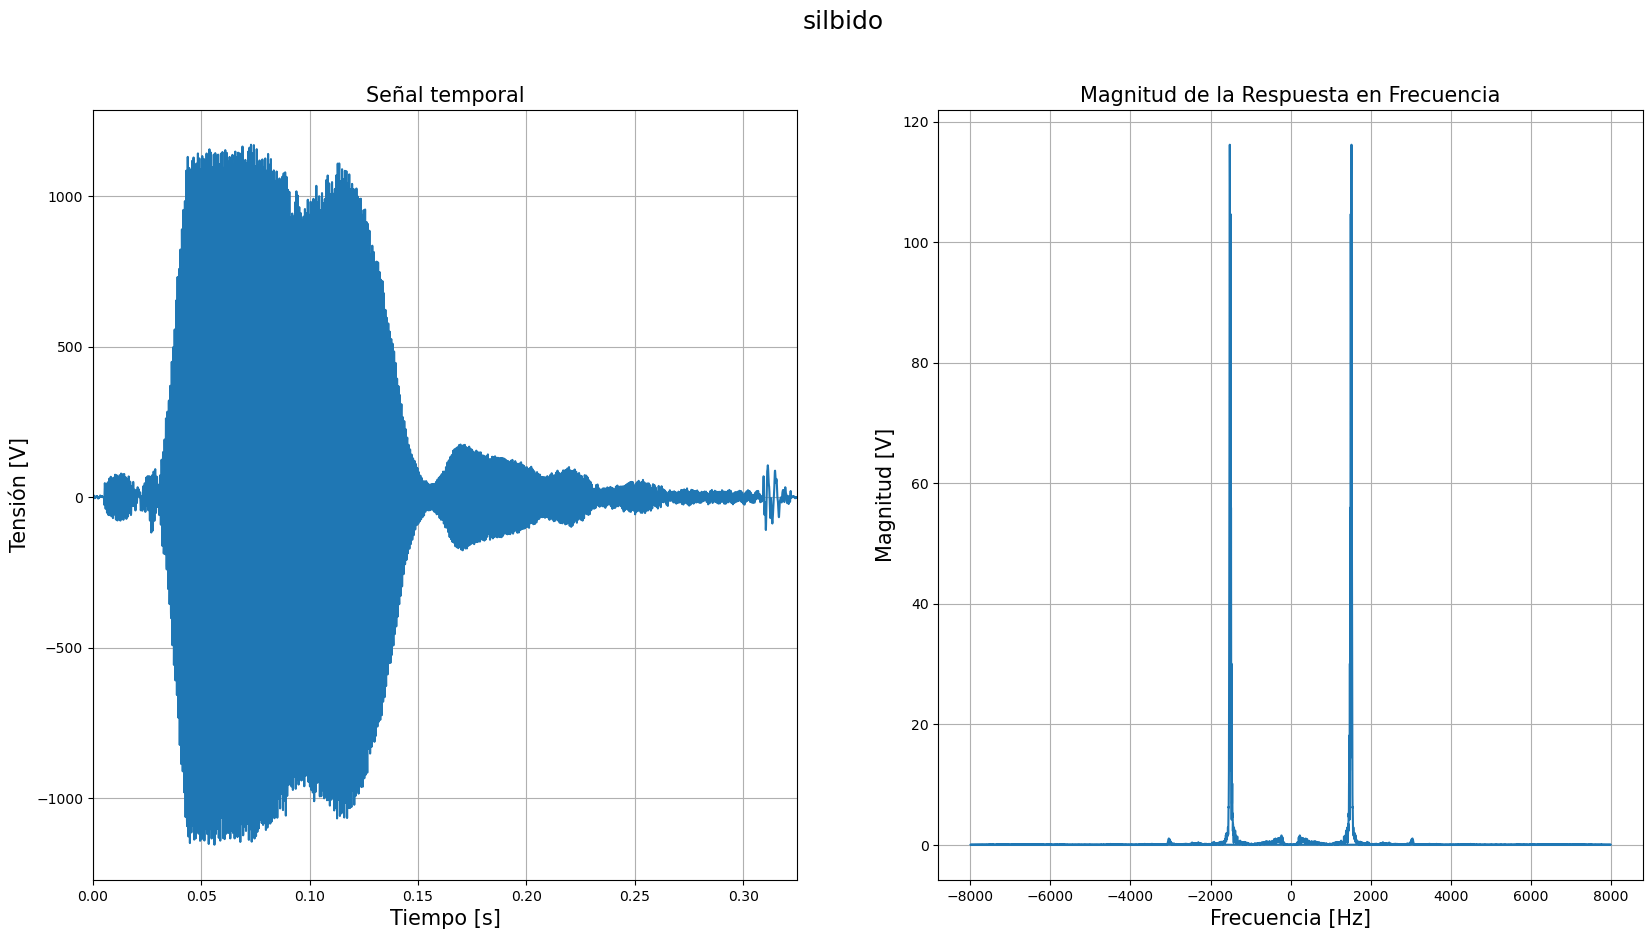

In [47]:
# Se crea una gráfica que contendrá dos sub-gráficos ordenados en una fila y dos columnas
fig1, ax1 = plt.subplots(1, 2, figsize=(20, 10))
fig1.suptitle(filename, fontsize=18)

# Se grafica la señal temporal
ax1[0].plot(t, senial)
ax1[0].set_xlabel('Tiempo [s]', fontsize=15)
ax1[0].set_ylabel('Tensión [V]', fontsize=15)
ax1[0].set_title('Señal temporal', fontsize=15)
ax1[0].set_xlim([0, ts*N])
ax1[0].grid()

# se grafica la magnitud de la respuesta en frecuencia
ax1[1].plot(freq, senial_fft_mod)
#ax1[1].plot(f, senial_fft_mod)
ax1[1].set_xlabel('Frecuencia [Hz]', fontsize=15)
ax1[1].set_ylabel('Magnitud [V]', fontsize=15)
ax1[1].set_title('Magnitud de la Respuesta en Frecuencia', fontsize=15)
#ax1[1].set_xlim([0, 2500])
ax1[1].grid()

plt.show()

## Análisis de armónicos

In [41]:
# Se calcula el espectro en potencia
senial_fft_pot = np.power(senial_fft_mod , 2)

# Se detecta la posición de los picos en la FFT
armonicos, _ = signal.find_peaks(senial_fft_pot,
                                 distance=10*N/fs,
                                 prominence=np.max(senial_fft_pot)/50)

print(f"La frecuencia fundamental del tono es de:")
print(f"  f0: {f[armonicos[0]]:.2f}Hz")

print("La frecuencia fundamental de los primeros 5 armónicos es de:")
for i in range(1, len(armonicos)):
    print(f"  f{i}: {f[armonicos[i]]:.2f}Hz")
    if i == 5:
        break

La frecuencia fundamental del tono es de:
  f0: 246.28Hz
La frecuencia fundamental de los primeros 5 armónicos es de:
  f1: 494.13Hz
  f2: 741.59Hz
  f3: 989.04Hz


### Graficación de armónicos


In [42]:
# Función para calcular la frecuencia de una nota, según la octava

def frecuencia(nota, octava):
    return 440 * np.exp(((octava-4) + ((nota-9)/12)) * np.log(2)) 

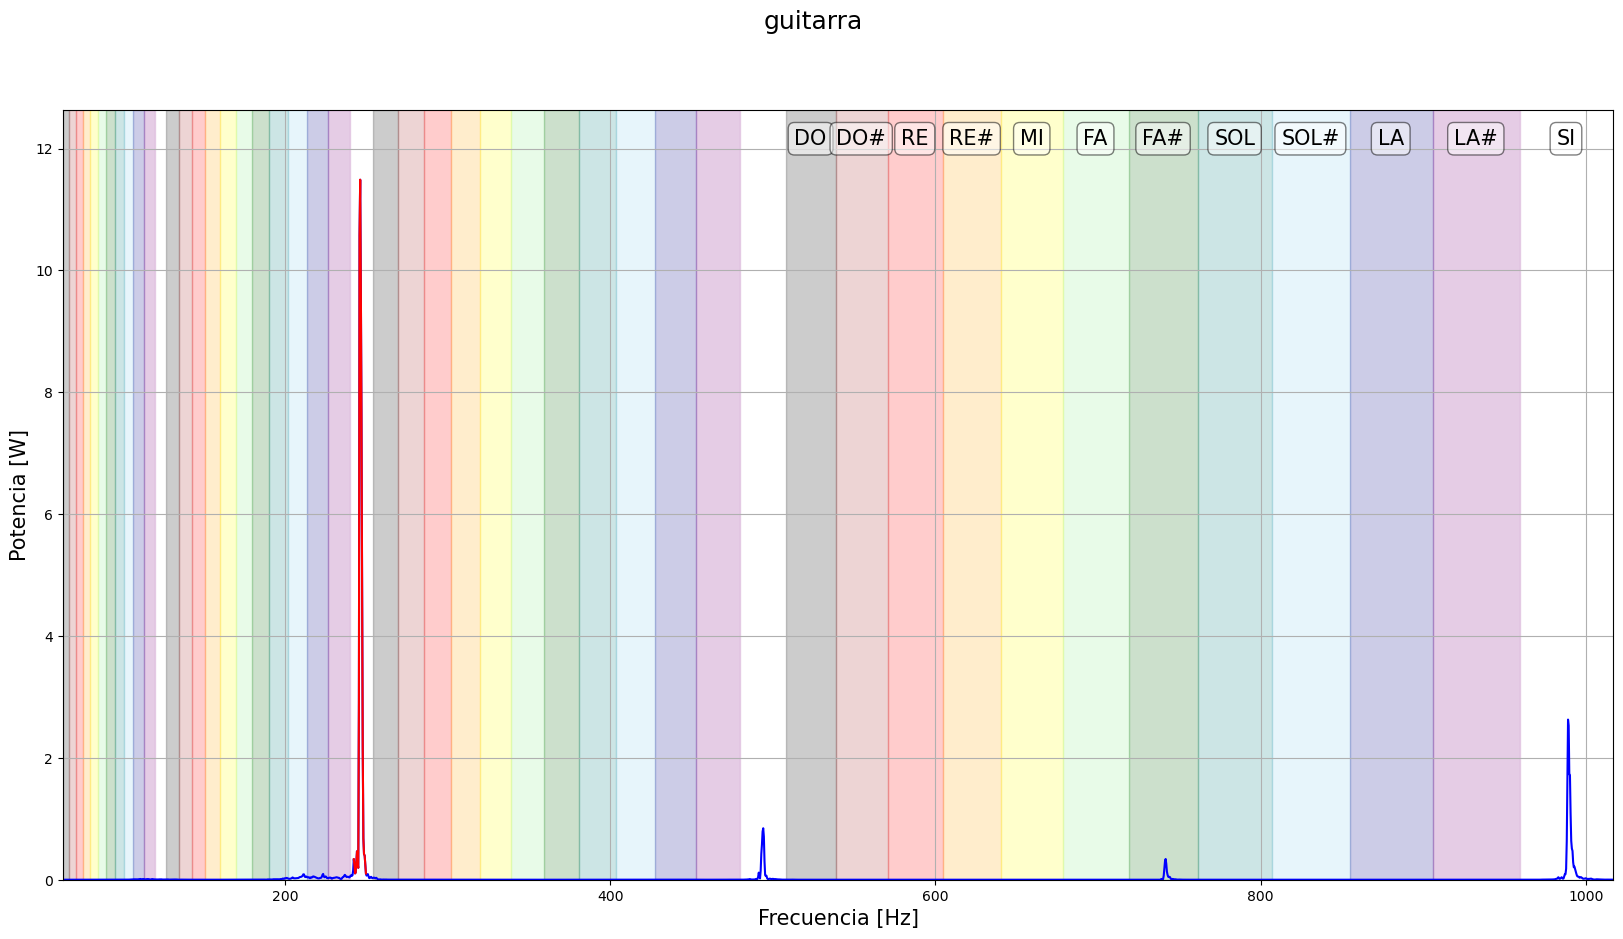

In [43]:
# Se crea una gráfica 
fig2, ax2 = plt.subplots(1, 1, figsize=(20, 10))
fig2.suptitle(filename, fontsize=18)

octava_inicial = 2
octava_final = 5

# Se grafica el espectro en potencia de la señal indicando la ubicación de los armónicos
ax2.plot(f, senial_fft_pot, label='FFT', zorder=2, color='blue')
ax2.plot(f[armonicos[0]-10 : armonicos[0]+10], 
         senial_fft_pot[armonicos[0]-10 : armonicos[0]+10], 
          label='Frec. fundamental',  color='red')
ax2.set_xlabel('Frecuencia [Hz]', fontsize=15)
ax2.set_ylabel('Potencia [W]', fontsize=15)
ax2.set_xlim([frecuencia(0-0.5, octava_inicial), frecuencia(0-0.5, octava_final+1)])
ax2.set_ylim(0, np.max(senial_fft_pot)*1.1)
# ax2.set_xscale("log")
ax2.grid()

# Se pinta el rango correspondiente a cada nota
notas = ['DO', 'DO#', 'RE', 'RE#', 'MI', 'FA', 'FA#', 'SOL', 'SOL#', 'LA', 'LA#', 'SI']
colores = ['black', 'brown', 'red', 'orange', 'yellow', 'lightgreen', 'darkgreen', 'teal', 'skyblue', 'darkblue', 'purple', 'white']
for octava in range(octava_inicial, octava_final+1):
    for nota in range(12):
        ax2.add_patch(plt.Rectangle((frecuencia(nota-0.5, octava), 0), 
                                    frecuencia(nota+0.5, octava)-(frecuencia(nota-0.5 ,octava)), 
                                    np.max(senial_fft_pot)*1.1, color=colores[nota], alpha=0.2))
for nota in range(12):
    ax2.text(frecuencia(nota, octava_final), np.max(senial_fft_pot)*1.05, 
                    f'{notas[nota]}', fontsize=15,
                    horizontalalignment='center',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))           
plt.show()


### Notas

![notas](frecuencia_notas.jpg)


### Acordes

![acordes](acordes.png)
